# Import all libraries

In [28]:
import pandas as pd
import sqlalchemy as sa
from sqlalchemy import create_engine
from datetime import datetime, timedelta, date
import datetime
import vertica_python
import io
from tqdm import tqdm
from clickhouse_driver import Client
import xlsxwriter
from prophet import Prophet
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from prophet.plot import plot_plotly
import scipy
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

login = 'ryunisov'
password = 'Winter2023'

settings = {
            'max_rows_to_group_by':1000000000000000000000000,
            'max_execution_time':9223372,
            'max_result_rows' :1000000000000000000000000
           }

conn_info_my = {
    'host': 'vertica-sandbox.s.o3.ru',
    'port': 5433,
    'user': login,
    'password': password,
    'database': 'OLAP'
    }

conn = vertica_python.connect(**conn_info_my)

# prepare all components for future dataset. Use list compehansion for generate date range

In [4]:
date_start = datetime.datetime.strptime('2020-01-01', '%Y-%m-%d')
date_end = datetime.datetime.strptime('2023-01-31', '%Y-%m-%d')

daterange = [(date_start + timedelta(days=x)).strftime('%Y-%m-%d') for x in range(((date_end-date_start).days)+1)]


brand_id = [7115299]

# Use database and load dataset by date and gmv

In [5]:
df = pd.DataFrame()
for date in daterange:
    print(f'{date} - uploaded')
    query = f"""
            SELECT  a.FactDate AS date,
            br.Name AS brand,
            SUM (SalesCommercial * Qty) AS gmv
    FROM metazonbeeeye.action a
             left join dwh_data.Anc_Item anc on anc.SourceKey = a.RezonItemID
             left join dwh_data.Atr_Item_Name i on i.ItemId = anc.ItemId
             left join dwh.Fact_Item_Brand fb ON anc.ItemId = fb.ItemID
             left join dwh.Dim_Brand br on br.BrandId = fb.BrandId
             LEFT JOIN metazonbeeeye.Supplier ms ON a.SupplierID = ms.ID
             LEFT JOIN metazonbeeeye.ItemType mi ON a.ItemTypeID = mi.ID
    WHERE FactDate = '{date}'
    AND ActionTypeID = 101
    AND br.ExternalKey IN ({brand_id[0]})
    AND SalesSchemaID = 11017671628710
    GROUP BY 	a.FactDate,
                br.Name;
                """
    result = pd.read_sql(query, conn)
    df = pd.concat([result, df])
df.sort_values('date').head(5)

2020-01-01 - uploaded
2020-01-02 - uploaded
2020-01-03 - uploaded
2020-01-04 - uploaded
2020-01-05 - uploaded
2020-01-06 - uploaded
2020-01-07 - uploaded
2020-01-08 - uploaded
2020-01-09 - uploaded
2020-01-10 - uploaded
2020-01-11 - uploaded
2020-01-12 - uploaded
2020-01-13 - uploaded
2020-01-14 - uploaded
2020-01-15 - uploaded
2020-01-16 - uploaded
2020-01-17 - uploaded
2020-01-18 - uploaded
2020-01-19 - uploaded
2020-01-20 - uploaded
2020-01-21 - uploaded
2020-01-22 - uploaded
2020-01-23 - uploaded
2020-01-24 - uploaded
2020-01-25 - uploaded
2020-01-26 - uploaded
2020-01-27 - uploaded
2020-01-28 - uploaded
2020-01-29 - uploaded
2020-01-30 - uploaded
2020-01-31 - uploaded
2020-02-01 - uploaded
2020-02-02 - uploaded
2020-02-03 - uploaded
2020-02-04 - uploaded
2020-02-05 - uploaded
2020-02-06 - uploaded
2020-02-07 - uploaded
2020-02-08 - uploaded
2020-02-09 - uploaded
2020-02-10 - uploaded
2020-02-11 - uploaded
2020-02-12 - uploaded
2020-02-13 - uploaded
2020-02-14 - uploaded
2020-02-15

,date,brand,gmv
0,2020-01-01,Huggies,1.619020e+06
0,2020-01-02,Huggies,2.452778e+06
0,2020-01-03,Huggies,2.871296e+06
0,2020-01-04,Huggies,3.073678e+06
0,2020-01-05,Huggies,3.312204e+06


# Construct distribution and check for normality

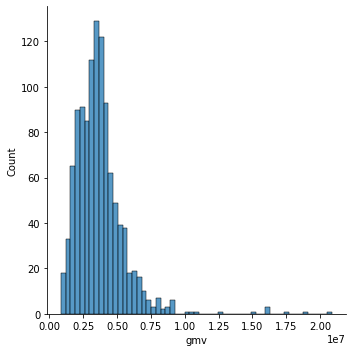

In [6]:
sns.displot(df['gmv'])

In [19]:
stat, p = scipy.stats.shapiro(df['gmv'])
print(f'P-value: {p:.38f}')
print(f'Stats: {stat}')

P-value: 0.00000000000000000000000000000000005376
Stats: 0.8017898201942444


# Preparing sampling for test and training

In [43]:
df_for_modeling = df[['date', 'gmv']].groupby('date').sum() \
                .reset_index() \
                .rename(columns={'date':'ds', 'gmv':'y'}) \
                .sort_values(by='ds', ascending=True)

# Start preparing data for the model by Prophet. Counting holidays and seasonality

In [67]:
model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)

model.add_country_holidays(country_name='RU')
model.fit(df_for_modeling)

future_prediction = model.make_future_dataframe(periods=30, freq='d')
future_prediction = future_prediction[-30:]

forecast = model.predict(future_prediction)
forecast.tail(5)

17:15:27 - cmdstanpy - INFO - Chain [1] start processing
17:15:27 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Defender of the Fatherland Day,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
25,2023-02-26,3.419008e+06,2.378486e+06,6.152395e+06,3.412817e+06,3.424915e+06,0.0,0.0,0.0,0.0,...,-386221.367814,-386221.367814,-386221.367814,1.298825e+06,1.298825e+06,1.298825e+06,0.0,0.0,0.0,4.331612e+06
26,2023-02-27,3.415896e+06,2.909621e+06,6.618408e+06,3.409283e+06,3.422432e+06,0.0,0.0,0.0,0.0,...,-37456.940497,-37456.940497,-37456.940497,1.421838e+06,1.421838e+06,1.421838e+06,0.0,0.0,0.0,4.800277e+06
27,2023-02-28,3.412784e+06,3.139819e+06,6.960096e+06,3.405612e+06,3.419850e+06,0.0,0.0,0.0,0.0,...,153577.660208,153577.660208,153577.660208,1.528571e+06,1.528571e+06,1.528571e+06,0.0,0.0,0.0,5.094932e+06
28,2023-03-01,3.409672e+06,3.349017e+06,7.026164e+06,3.401810e+06,3.417492e+06,0.0,0.0,0.0,0.0,...,153054.939271,153054.939271,153054.939271,1.616067e+06,1.616067e+06,1.616067e+06,0.0,0.0,0.0,5.178794e+06
29,2023-03-02,3.406560e+06,3.410766e+06,7.102349e+06,3.398164e+06,3.415646e+06,0.0,0.0,0.0,0.0,...,236190.942123,236190.942123,236190.942123,1.681762e+06,1.681762e+06,1.681762e+06,0.0,0.0,0.0,5.324513e+06


In [63]:
mse = mean_squared_error(df_test['y'], forecast['yhat'])
mse = np.sqrt(mse)
print(f'RMSE - {mse:.2f}')

RMSE - 2188857.60


# Draw diagrams

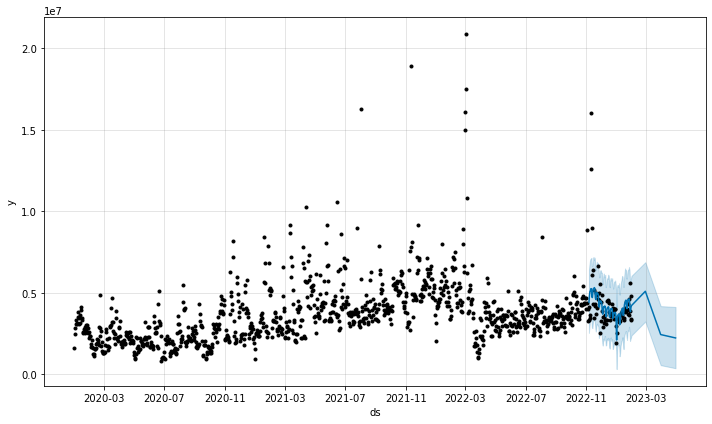

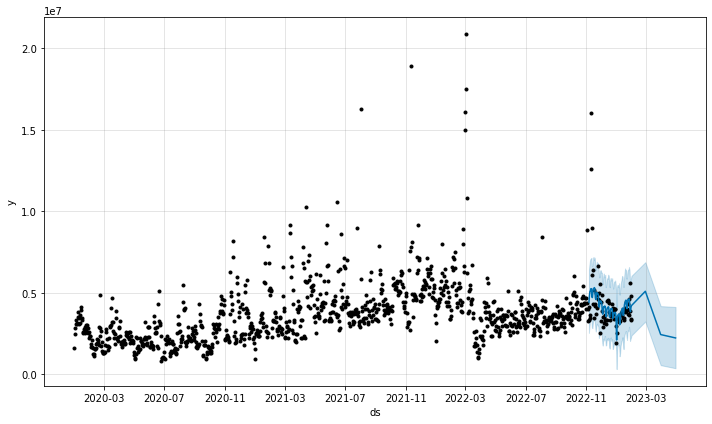

In [48]:
model.plot(forecast)

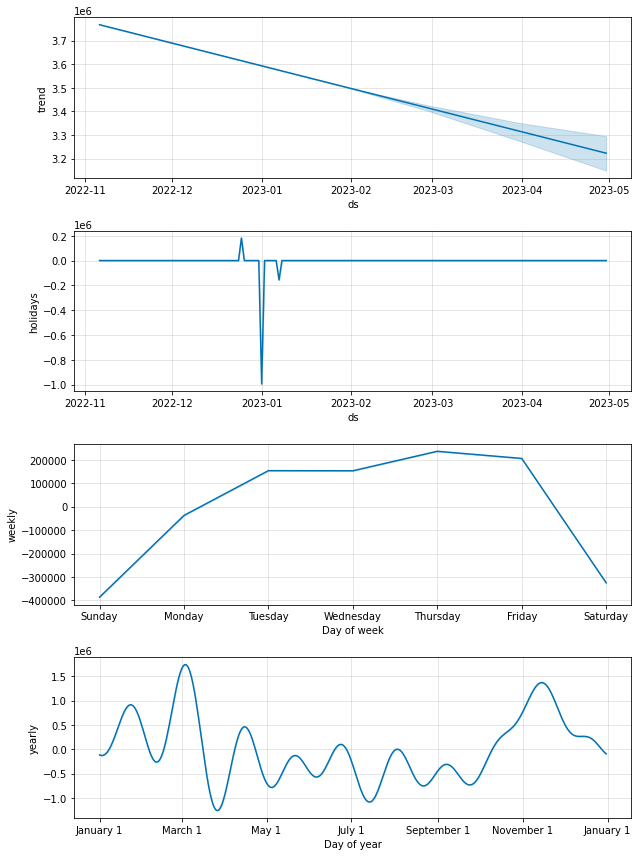

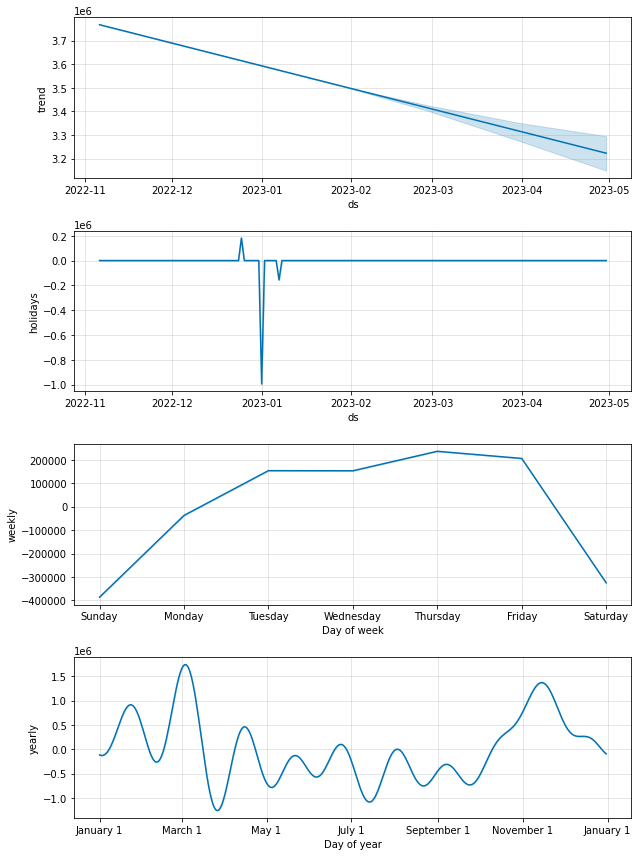

In [49]:
model.plot_components(forecast)

In [50]:
plot_plotly(model, forecast)

# Considering the model. MAPE and MAE and R2

In [68]:
df_cv = cross_validation(model, initial='730 days', period='30 days', horizon = '365 days')
df_p = performance_metrics(df_cv)
df_p.head()

  0%|          | 0/2 [00:00<?, ?it/s]

17:15:35 - cmdstanpy - INFO - Chain [1] start processing
17:15:35 - cmdstanpy - INFO - Chain [1] done processing
17:15:36 - cmdstanpy - INFO - Chain [1] start processing
17:15:36 - cmdstanpy - INFO - Chain [1] done processing


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,37 days,1.054241e+13,3.246908e+06,1.866576e+06,0.270319,0.211523,0.273858,0.657534
1,38 days,1.054936e+13,3.247978e+06,1.871504e+06,0.268530,0.211523,0.273244,0.643836
2,39 days,1.053091e+13,3.245137e+06,1.864027e+06,0.266178,0.192817,0.271382,0.643836
3,40 days,1.048424e+13,3.237937e+06,1.841958e+06,0.262656,0.192817,0.267672,0.650685
4,41 days,1.043625e+13,3.230519e+06,1.821729e+06,0.259860,0.189766,0.264402,0.664384


In [69]:
df_p.nsmallest(5, 'mape')

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
6,43 days,1.039094e+13,3.223498e+06,1.803758e+06,0.257561,0.185851,0.261190,0.678082
5,42 days,1.041960e+13,3.227941e+06,1.814748e+06,0.258482,0.189766,0.262927,0.671233
4,41 days,1.043625e+13,3.230519e+06,1.821729e+06,0.259860,0.189766,0.264402,0.664384
7,44 days,1.035985e+13,3.218672e+06,1.796848e+06,0.260041,0.185851,0.261408,0.678082
3,40 days,1.048424e+13,3.237937e+06,1.841958e+06,0.262656,0.192817,0.267672,0.650685


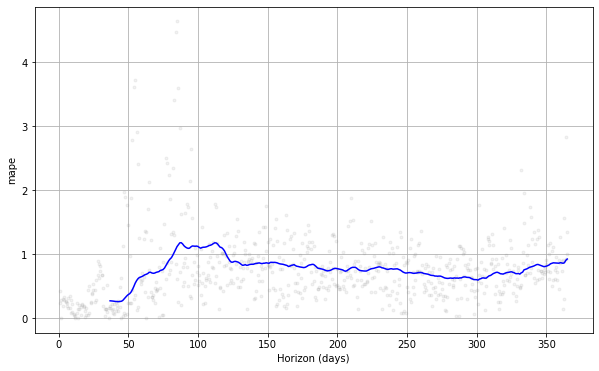

In [70]:
fig = plot_cross_validation_metric(df_cv, metric='mape')
fig.show()

In [ ]:
def forecast_validation(full_df,max_month,future_period):
    
    param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5,10],
    'seasonality_prior_scale': [0.001, 0.01, 0.1, 0.5,10],
    'holidays_prior_scale': [0.001, 0.01, 0.1, 0.5,10],
    'seasonality_mode': ['additive', 'multiplicative']
    }
    
    #Сгенерируем все параметры 
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    mae = []  # Cюда добавим среднюю ошибку за 12 месяцев для конкретного сочетания значений параметров
    last_mae = [] # Cюда добавим ошибку за последний месяц 

    for params in all_params:
        params['holidays'] = ru_holidays
        
        new_df = full_df.query(f'ds < "{max_month}" ')

        m = Prophet(**params).fit(new_df) ## Вызываем пророка и фитим модель

        ## Формируем ДФ с прогнозными значениями 
        future = m.make_future_dataframe(periods=future_period) 
        forecast = m.predict(future)[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

        ## Готовим ДФы для сравнения факта и прогноза
        full_df['month'] = full_df.ds.apply(lambda x: str(x)[:7])
        forecast['month'] = forecast.ds.apply(lambda x: str(x)[:7])

        days_limited = (datetime.date(int(max_month[:4]),int(max_month[5:7]),int(max_month[8:10])) + timedelta(days=future_period))\
            .strftime("%Y-%m-%d")

        cmp_df = forecast.groupby('month').agg({'yhat':'sum'})[['yhat']]\
            .join(full_df.query(f'ds < "{days_limited}" ')\
            .groupby('month').agg({'y':'sum'}))

        cmp_df['MAPE'] = cmp_df['y'] - cmp_df['yhat']
        cmp_df['MAE'] = 100*cmp_df['MAPE']/cmp_df['y']

        ## Считаем MAE за 12 месяцев и последний месяц
        mae.append(np.mean(abs(cmp_df[-12:]['MAE'])))
        last_mae.append(np.mean(abs(cmp_df[-1:]['MAE'])))
    
    tuning_results = pd.DataFrame(all_params)
    tuning_results['mae'] = mae
    tuning_results['last_mae'] = last_mae
    tuning_results = tuning_results.sort_values(by = 'last_mae')
   
    return tuning_results

# Unload prediction in Excel

In [60]:
df_forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

In [61]:
writer = pd.ExcelWriter('forecast_by_brand.xlsx', engine='xlsxwriter')
df_forecast.to_excel(writer, sheet_name='forecast')
writer.close()